In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# Any results you write to the current directory are saved as output.

In [ ]:
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.layers import Flatten, Dense, LSTM, Dropout, Embedding, Activation
from keras.layers import concatenate, BatchNormalization, Input
from keras.layers.merge import add
from tensorflow.keras.utils import to_categorical
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import cv2
import string
import time
print("Running.....")



Running.....


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
token_path = '/content/drive/MyDrive/captions.txt'
text = open(token_path, 'r', encoding = 'utf-8').read()
print(text[:500])


image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3


In [ ]:
def load_description(text):
    mapping = dict()
    for line in text.split("\n"):
        token = line.split("\t")
        if len(line) < 2:
            continue
        img_id = token[0].split('.')[0]
        img_des = token[0]
        if img_id not in mapping:
            mapping[img_id] = list()
        mapping[img_id].append(img_des)
    return mapping

descriptions = load_description(text)
print("Number of items: " + str(len(descriptions)))

Number of items: 8092


In [ ]:
descriptions['1000268201_693b08cb0e']

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .']

In [ ]:
def clean_description(desc):
    for key, des_list in desc.items():
        for i in range(len(des_list)):
            caption = des_list[i]
            caption = [ch for ch in caption if ch not in string.punctuation]
            caption = ''.join(caption)
            caption = caption.split(' ')
            caption = [word.lower() for word in caption if len(word)>1 and word.isalpha()]
            caption = ' '.join(caption)
            des_list[i] = caption

clean_description(descriptions)
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
def to_vocab(desc):
    words = set()
    for key in desc.keys():
        for line in desc[key]:
            words.update(line.split())
    return words
vocab = to_vocab(descriptions)
len(vocab)

8681

In [ ]:
import glob
images = '/content/drive/MyDrive/Image dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')
len(img)

8091

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_path = '/content/drive/MyDrive/Flickr_8k.trainImages.txt'
train_images = open(train_path, 'r', encoding = 'utf-8').read().split("\n")
train_img = []

for im in img:
    if(im[len(images):] in train_images):
        train_img.append(im)

In [ ]:
test_path = '/content/drive/MyDrive/Flickr_8k.testImages.txt'
test_images = open(test_path, 'r', encoding = 'utf-8').read().split("\n")
test_img = []

for im in img:
    if(im[len(images): ] in test_images):
        test_img.append(im)
len(test_img)

1000

In [ ]:
#load descriptions of train and test set separately
def load_clean_descriptions(des, dataset):
    dataset_des = dict()
    for key, des_list in des.items():
        if key+'.jpg' in dataset:
            if key not in dataset_des:
                dataset_des[key] = list()
            for line in des_list:
                desc = 'startseq ' + line + ' endseq'
                dataset_des[key].append(desc)
    return dataset_des

train_descriptions = load_clean_descriptions(descriptions, train_images)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [ ]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
def preprocess_img(img_path):
    #inception v3 excepts img in 299*299
    img = load_img(img_path, target_size = (299, 299))
    x = img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis = 0)
    x = preprocess_input(x)
    return x

In [ ]:
base_model = InceptionV3(weights = 'imagenet')
base_model.summary()

96124928/96112376 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)           

In [ ]:
model = Model(base_model.input, base_model.layers[-2].output)

In [ ]:
#function to encode an image into a vector using inception v3
def encode(image):
    image = preprocess_img(image)
    vec = model.predict(image)
    vec = np.reshape(vec, (vec.shape[1]))
    return vec

In [ ]:
#run the encode function on all train images
start = time.time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time Taken is: " + str(time.time() - start))

Time Taken is: 5421.639742851257


In [ ]:
#Encode all the test images
start = time.time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken is: " + str(time.time() - start))

Time taken is: 915.0843243598938


In [ ]:
train_features = encoding_train
test_features = encoding_test
print("Train image encodings: " + str(len(train_features)))
print("Test image encodings: " + str(len(test_features)))

Train image encodings: 6000
Test image encodings: 1000


In [ ]:
train_features['1000268201_693b08cb0e.jpg'].shape

(2048,)

In [ ]:
#list of all training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for caption in val:
        all_train_captions.append(caption)
len(all_train_captions)

30000

In [ ]:
#Consider only words which occur atleast 10 times
vocabulary = vocab
threshold = 10
word_counts = {}
for cap in all_train_captions:
    for word in cap.split(' '):
        word_counts[word] = word_counts.get(word, 0) + 1

vocab = [word for word in word_counts if word_counts[word] >= threshold]
print("Unique words: " + str(len(word_counts)))
print("our Vocabulary: " + str(len(vocab)))


Unique words: 7506
our Vocabulary: 1631


In [ ]:
#word mapping to integers
ixtoword = {}
wordtoix = {}

ix = 1
for word in vocab:
    wordtoix[word] = ix
    ixtoword[ix] = word
    ix += 1

In [ ]:
vocab_size = len(ixtoword) + 1  #1 for appended zeros
vocab_size

1632

In [ ]:
#find the maximum length of a description in a dataset
max_length = max(len(des.split()) for des in all_train_captions)
max_length


33

In [ ]:
#since there are almost 30000 descriptions to process we will use datagenerator
X1, X2, y = list(), list(), list()
for key, des_list in train_descriptions.items():
    pic = train_features[key + '.jpg']
    for cap in des_list:
        seq = [wordtoix[word] for word in cap.split(' ') if word in wordtoix]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
            out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
            #store
            X1.append(pic)
            X2.append(in_seq)
            y.append(out_seq)

X2 = np.array(X2)
X1 = np.array(X1)
y = np.array(y)
print(X1.shape)

(280732, 2048)


In [ ]:
#load glove vectors for embedding layer
embeddings_index = {}
glove = open('/content/drive/MyDrive/glove/glove.6B.200d.txt', 'r', encoding = 'utf-8').read()
for line in glove.split("\n"):
    values = line.split(" ")
    word = values[0]
    indices = np.asarray(values[1: ], dtype = 'float32')
    embeddings_index[word] = indices
print('Total word vectors: ' + str(len(embeddings_index)))

Total word vectors: 400001


In [ ]:
emb_dim = 200
emb_matrix = np.zeros((vocab_size, emb_dim))
for word, i in wordtoix.items():
    emb_vec = embeddings_index.get(word)
    if emb_vec is not None:
        emb_matrix[i] = emb_vec
emb_matrix.shape

(1632, 200)

In [ ]:
# define the model
ip1 = Input(shape = (2048, ))
fe1 = Dropout(0.2)(ip1)
fe2 = Dense(256, activation = 'relu')(fe1)
ip2 = Input(shape = (max_length, ))
se1 = Embedding(vocab_size, emb_dim, mask_zero = True)(ip2)
se2 = Dropout(0.2)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)
model = Model(inputs = [ip1, ip2], outputs = outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 33, 200)      326400      ['input_4[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_3[0][0]']                
                                                                                            

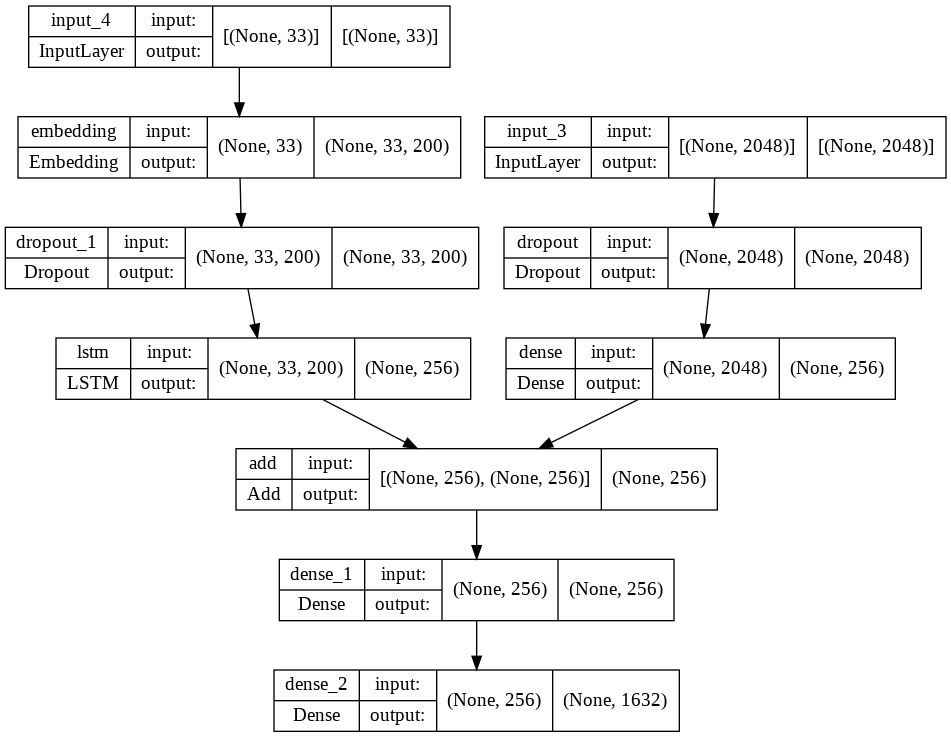

In [ ]:
model.layers[2].set_weights([emb_matrix])
model.layers[2].trainable = False
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
plot_model(model, to_file = 'model.png', show_shapes = True, show_layer_names = True)

In [ ]:
model.layers[2]

In [ ]:
for i in range(30):
    model.fit([X1, X2], y, epochs = 1, batch_size = 256)
    if(i%2 == 0):
        model.save_weights("image-caption-weights" + str(i) + ".h5")

1097/1097 [==============================] - 575s 524ms/step - loss: 1.8590


In [ ]:
def greedy_search(pic):
    start = 'startseq'
    for i in range(max_length):
        seq = [wordtoix[word] for word in start.split() if word in wordtoix]
        seq = pad_sequences([seq], maxlen = max_length)
        yhat = model.predict([pic, seq])
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        start += ' ' + word
        if word == 'endseq':
            break
    final = start.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

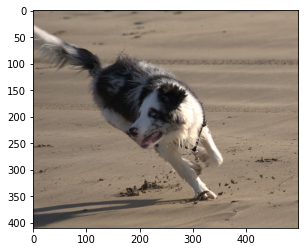

dog is running on the beach


In [ ]:
pic = list(encoding_test.keys())[250]
img = encoding_test[pic].reshape(1, 2048)
x = plt.imread(images + pic)
plt.imshow(x)
plt.show()
print(greedy_search(img))

In [ ]:
model.save("my_model.h5")

In [ ]:
#train it for some more time
model.fit([X1, X2], y, epochs = 1, batch_size = 64)
model.save("my_model_"+str(i)+".h5")

4387/4387 [==============================] - 887s 202ms/step - loss: 2.2316


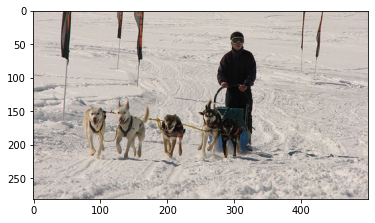

dogs are running through the snow


In [ ]:
pic = list(encoding_test.keys())[876]
img = encoding_test[pic].reshape(1, 2048)
x = plt.imread(images + pic)
plt.imshow(x)
plt.show()
print(greedy_search(img))

In [ ]:
model.save("my-cap.h5")

In [ ]:
hypothesis = "dogs are running through the snow"
hypothesis = hypothesis.split()
reference  = "The dogs are running through the snow"
references = [reference.split()] ## references must be a list containing list. 

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
print("BLEU={:4.3f}".format(sentence_bleu(references,hypothesis)))

BLEU=0.846
